In [1]:
import sys, os, glob, yaml

In [2]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
import pprint
import seaborn as sns
import trackml.dataset

In [4]:
import torch
from torch_geometric.data import Data
import itertools

In [5]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

## _Inspection on Track Duplication_

- lets plot two reconstructed events, one is `clean` and the other a little `complex`
- see an event with duplicated tracks, find out why they are duplicated.

In [6]:
sys.path.append('..')

In [7]:
from src.drawing import detector_layout, draw_proc_event
from src.utils_math import polar_to_cartesian

In [8]:
event_idx = 1

In [9]:
# get list of true tracks (test dataset)
inputdir="run/feature_store/test"
true_trkx = sorted(glob.glob(os.path.join(inputdir, "*")))

In [10]:
# event Data
true_trkx_data = torch.load(true_trkx[event_idx], map_location=device)
print("Length of Data: {}".format(len(true_trkx_data)))

Length of Data: 10


In [11]:
true_trkx_data

Data(x=[171, 3], pid=[171], layers=[171], event_file='/global/cscratch1/sd/aakram/train_all/event0000095001', hid=[171], pt=[171], modulewise_true_edges=[2, 160], layerwise_true_edges=[2, 172], edge_index=[2, 808], y_pid=[808])

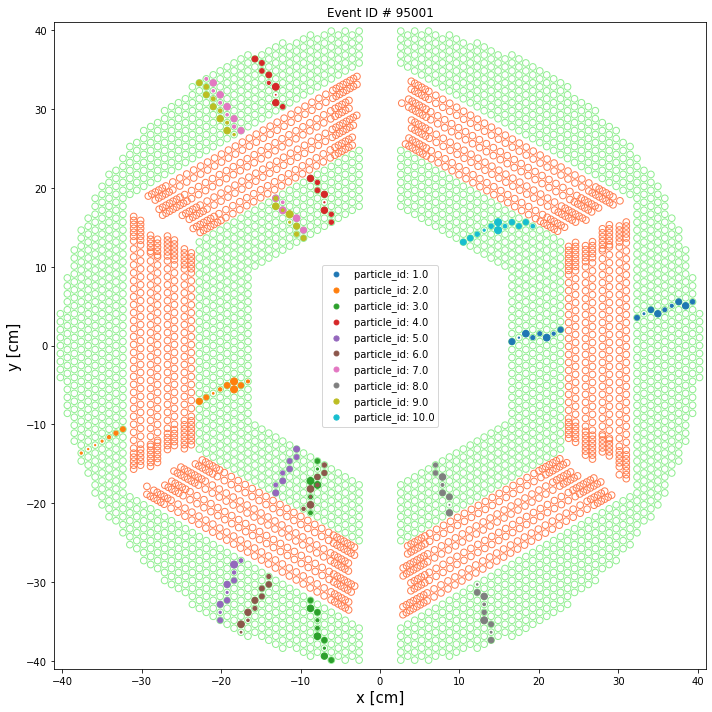

In [12]:
# draw true trkx data
draw_proc_event(true_trkx_data,figsize=(10,10),save_fig=False);

In [13]:
print("Track Id: ", reco_trkx[event_idx])

NameError: name 'reco_trkx' is not defined

In [ ]:
reco_trkx_data = torch.load(reco_trkx[event_idx], map_location=device)
print("Length of Data: {}".format(len(reco_trkx_data)))

In [ ]:
reco_trkx_data.head()

In [ ]:
inputdir="run/trkx_reco_eval"

In [ ]:
evtid = int(reco_trkx[event_idx][-4:])

In [ ]:
print("evtid: {}".format(evtid))

In [ ]:
!./eval.sh $evtid

In [ ]:
# path to HDF5 Store
hdf5_path = inputdir+"/{}_particles.h5".format(evtid)
print(hdf5_path)

In [ ]:
df = pd.read_hdf(hdf5_path)
print("Length of Data: {}".format(len(df)))

In [ ]:
df.head()

In [ ]:
# Read the Summary of Evaluation
sum_path = inputdir+"/{}_summary.txt".format(evtid)
print(sum_path)

In [ ]:
with open(sum_path) as f:
    contents = f.read()
    print(contents)

## _(1.) - Plot True Event (Clean)_

In [14]:
# The Good Event
event_id = 96

In [15]:
# true events
true_trkx = torch.load(proc_files[event_id], map_location=device)

NameError: name 'proc_files' is not defined

In [ ]:
true_trkx

In [ ]:
np.unique(true_trkx.pid)

In [ ]:
# hit features
r, phi, ir = true_trkx.x.T

In [ ]:
# spatial coordinate transform
x, y = polar_to_cartesian(r.detach().numpy(), phi.detach().numpy())

In [ ]:
# compensate scaling
ir = ir.detach().numpy()*100

In [ ]:
# plot true event
fig, ax = detector_layout(figsize=(10,10))
e_id = int(true_trkx.event_file[-10:])
p_ids = np.unique(true_trkx.pid)

for pid in p_ids:
    idx = true_trkx.pid == pid
    ax.plot(x[idx], y[idx], '-', linewidth=1.5)
    ax.scatter(x[idx], y[idx], s=(ir[idx]*50), label='particle_id: {}'.format(pid))

ax.set_title('Azimuthal View of STT, EventID # {}'.format(e_id))
#ax.legend(fontsize=10, loc='best')
fig.tight_layout()

## _(2.) - Plot Reco Event (Good)_

In [ ]:
# lets plot reconstructed true event, i.e. event = 96
reco_trkx = torch.load(trkx_from_gnn[event_id], map_location=device)

In [ ]:
reco_trkx.head()

Now, we've only the `hit_id` and `track_id`, what are corresponding spatial coordinates (x,y coordinates)? How about using `hit_id` to filter features from the true event?

Note, the `hit_id`, `track_id` in reco data are equiv. to `hid`, `pid` in true data.

In [ ]:
# plot reco event, here, (x,y,ir) comes from ture event. but idx is from reco event
fig, ax = detector_layout(figsize=(10,10))
e_id = e_id
t_ids = np.unique(reco_trkx.track_id)
for tid in t_ids:
    idx = reco_trkx.track_id == tid
    ax.plot(x[idx], y[idx], '-', linewidth=1.5)
    ax.scatter(x[idx], y[idx], s=(ir[idx]*50), label='particle_id: {}'.format(tid))
    
ax.set_title('Azimuthal View of STT, EventID # {}'.format(e_id))
#ax.legend(fontsize=10, loc='best')
fig.tight_layout()

In [ ]:
!./eval.sh $e_id

In [ ]:
with open("run/trkx_reco_eval/{}_summary.txt".format(e_id)) as f:
    contents = f.read()
    print(contents)

## _(3.) - Plot True Event (Complex)_

In [ ]:
# The Bad Event
event_id = 90

In [ ]:
# true events
true_trkx = torch.load(proc_files[event_id], map_location=device)

In [ ]:
true_trkx

In [ ]:
np.unique(true_trkx.pid)

In [ ]:
# hit features
r, phi, ir = true_trkx.x.T

In [ ]:
# spatial coordinate transform
x, y = polar_to_cartesian(r.detach().numpy(), phi.detach().numpy())

In [ ]:
# compensate scaling
ir = ir.detach().numpy()*100

In [ ]:
# plot true event
fig, ax = detector_layout(figsize=(10,10))
e_id = int(true_trkx.event_file[-10:])
p_ids = np.unique(true_trkx.pid)

for pid in p_ids:
    idx = true_trkx.pid == pid
    ax.plot(x[idx], y[idx], '-', linewidth=1.5)
    ax.scatter(x[idx], y[idx], s=(ir[idx]*50), label='particle_id: {}'.format(pid))

ax.set_title('Azimuthal View of STT, EventID # {}'.format(e_id))
ax.legend(fontsize=10, loc='best')
fig.tight_layout()

## _(4.) - Plot Reco Event (Complex)_

In [ ]:
# lets plot reconstructed true event, i.e. event = 96
reco_trkx = torch.load(trkx_from_gnn[event_id], map_location=device)

In [ ]:
reco_trkx.head()

In [ ]:
np.unique(reco_trkx.track_id)

Now, we've only the `hit_id` and `track_id`, what are corresponding spatial coordinates (x,y coordinates)? How about using `hit_id` to filter features from the true event?

Note, the `hit_id`, `track_id` in reco data are equiv. to `hid`, `pid` in true data.

In [ ]:
# plot reco event, here, (x,y,ir) comes from ture event. but idx is from reco event
fig, ax = detector_layout(figsize=(10,10))
e_id = e_id
t_ids = np.unique(reco_trkx.track_id)
for tid in t_ids:
    idx = reco_trkx.track_id == tid
    ax.plot(x[idx], y[idx], '-', linewidth=2)
    ax.scatter(x[idx], y[idx], s=(ir[idx]*100), label='particle_id: {}'.format(tid))
    
ax.set_title('Azimuthal View of STT, EventID # {}'.format(e_id))
ax.legend(fontsize=10, loc='best')
fig.tight_layout()

In [ ]:
!./eval.sh $e_id

In [ ]:
with open("run/trkx_reco_eval/{}_summary.txt".format(e_id)) as f:
    contents = f.read()
    print(contents)

### (4.a) - Unassigned Hits

What is _`track_id=-1`_ contains?

The _hits_ not assigned to any track are collected under `track_id=-1`.

In [ ]:
dup_hids = reco_trkx.query("track_id==-1")["hit_id"]

In [ ]:
dup_hids.values

In [ ]:
# lets plot the duplicated hits
fig, ax = detector_layout(figsize=(10,10))
e_id = e_id

tid = -1
idx = reco_trkx.track_id == tid
ax.plot(x[idx], y[idx], '-', linewidth=0.5)
ax.scatter(x[idx], y[idx], s=(ir[idx]*50), label='particle_id: {}'.format(tid))
    
ax.set_title('Azimuthal View of STT, EventID # {}'.format(e_id))
ax.legend(fontsize=10, loc='best')
fig.tight_layout()